In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [3]:
# Load initial dataset
datafile = 'ex3/ex3data1.mat'
data = sio.loadmat(datafile)
X, Y = data['X'], data['y']
m = len(Y)
# X is a 5000 x 400 matrix. 5000 training samples of digit images written
# as a 20x20 images 'unrolled' into a 400-dimensional vector.
# each row is a training example.
print X.shape

# 5000 x 1 matrix representing the labels for our training set
# Digits are stored as 1-10, where 10 represents '0'
print Y.shape

(5000, 400)
(5000, 1)


### Visualizing the data

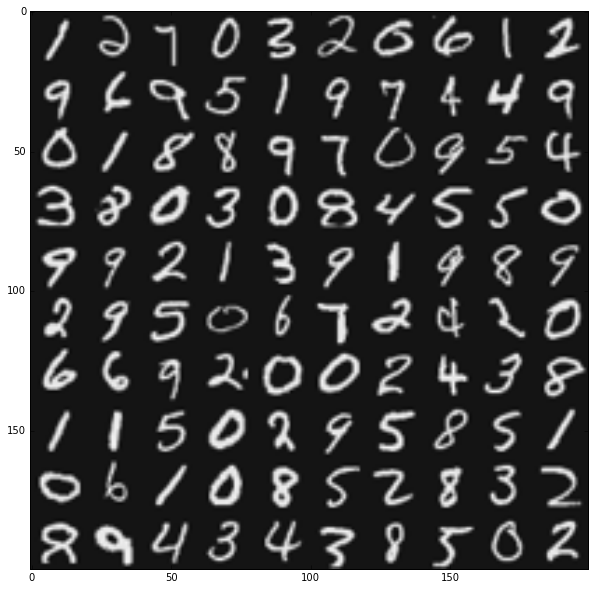

In [4]:
import random
import scipy.misc

# Compute number of items to display
display_rows, display_cols = 10, 10

total_digits = display_rows * display_cols

# Compute the size of each item to be displayed
example_height, example_width = 20, 20

# Get random indices to be displayed.
# random.sample(population,k) 
# where k is the number of items to select from the population
rows_to_display = random.sample(range(X.shape[0]),total_digits)

# Create initial picture by multiplying
# the number of rows to be displayed + the height of one digit
# and the nubmer of cols to be displayed + the width of one digit
picture = np.zeros((display_rows * example_height, display_cols * example_width))

curr_row, curr_col = 0, 0
for row in rows_to_display:
    if curr_col == display_cols:
        curr_col = 0
        curr_row += 1
    
    # Get digit image from 400x1 row. (Transform to 20x20)
    curr_digit = X[row].reshape(example_height, example_width).T
    
    # Row and col to be replaced with digit
    modified_row = curr_row * example_height
    modified_col = curr_col * example_width
    
    # Get specific and replace
    picture[modified_row:modified_row + curr_digit.shape[0],modified_col:modified_col + curr_digit.shape[1]] = curr_digit
    curr_col += 1

# Display image
image = scipy.misc.toimage(picture)
plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')

#### Vectorizing the cost function

In [5]:
from scipy.special import expit

# Hypothesis function for logistic regression.
def hypothesis(X,weights):
    return expit(np.dot(X,weights))

# Unregularized cost function for logistic regression (vectorized).
def compute_cost(weights, X, Y):
    first = np.dot(Y.T, np.log(hypothesis(X, weights)))
    second = np.dot((1 - Y).T, np.log(1 - hypothesis(X, weights)))
    return np.sum(-(1./m) * (first + second))

#### Vectorizing the gradient

In [6]:
# Regularized + vectorized gradient descent for logistic regression
def gradient(weights, X, Y, lmbda=0.):
    regularization_term = (lmbda/m) * weights[1:] # Avoid first theta
    gradient = (1./m) * np.dot(X.T, hypothesis(X, weights) - Y)
    gradient[1:] = gradient[1:] + regularization_term
    return gradient

#### Vectorizing regularized logistic regression

In [7]:
# Cost function for regularizied logistic regression (vectorized)
def compute_cost_regularized(weights, X, Y, lmbda=0.):
    first = np.dot(Y.T, np.log(hypothesis(X, weights)))
    second = np.dot((1 - Y).T, np.log(1 - hypothesis(X, weights)))
    cost = -(1./m) * (first + second) + (lmbda/2 * np.sum(np.dot(weights[1:].T, weights[1:]))) # Skip the first term
    return np.sum(cost)

#### One vs All classification

In [8]:
# Add to X the column of 1'sxt
X = np.insert(X,0,1,axis=1)

In [9]:
"""
You will be using fmincg for this exercise (instead of fminunc). 
fmincg works similarly to fminunc, but is more more efficient for dealing with
a large number of parameters.
"""
# Scipy implementation is scipy.optimize.fmin_cg
from scipy.optimize import fmin_cg

def optimize_weights(weights,X,Y,lmbd=0.):
    result = fmin_cg(compute_cost_regularized, fprime=gradient, x0=weights, \
                              args=(X, Y, lmbd), maxiter=150, disp=False,\
                              full_output=True)
    return result[0], result[1]

In [10]:
# Training a one-vs-all classifier for K classes
# Classes are denoted from 1..10 (where 10 means the digit '0')
# Basically we will train 10 logistic regression classifiers for each class
# And return a matrix of optimum weights of size 10 x (N + 1), N - number of features + '1'- bias

# # Number of classes
K = 10

# Matrix of final optimum weights
final_optimum = np.zeros((10,X.shape[1]))

# Initial weights for every classifier
initial_weights = np.zeros((X.shape[1],1)).reshape(-1)

for digit in range(K):
    digit_class = digit if digit != 0 else 10

    # Create y labels with 1 for current class and 0 otherwise
    y_digit = np.array([1 if i==digit_class else 0 for i in Y])
    
    # Compute optimum weights
    optimized_weights, min_cost = optimize_weights(initial_weights, X, y_digit)
    
    final_optimum[digit] = optimized_weights
    
print "Finished"

Finished


In [11]:
def predict_digit(image_as_row):
    digits = [10,1,2,3,4,5,6,7,8,9]
    probabilities = [0] * len(digits)
    
    for digit in range(len(digits)):
        probabilities[digit] = hypothesis(image_as_row, final_optimum[digit])
        
    max_index = max(enumerate(probabilities),key=lambda x: x[1])[0]
    return digits[max_index]

In [12]:
correct_predictions = 0

for row in range(X.shape[0]):
    predicted_digit = predict_digit(X[row])
    
    if predicted_digit == Y[row]:
        correct_predictions += 1
        
print str(float(correct_predictions) / float(X.shape[0]) * 100) + '% accuracy.'  

96.52% accuracy.


## Neural networks

In [13]:
# Task: Implement feedforward propagation algorithm to use pre-trained weights for prediction.

In [19]:
datafile2 = 'ex3/ex3weights.mat'
weights_data = sio.loadmat(datafile2)

Theta1, Theta2 = weights_data['Theta1'], weights_data['Theta2']
# The parameters have dimensions that are sized for a neural network with
# 25 units in the second layer and 10 output units (corresponding to 10 digits classes).

# Theta1 has size 2 x 401
print Theta1.shape

# Theta2 has size 10 x 26
print Theta2.shape

(25, 401)
(10, 26)


### Feedforward Propagation and Prediction

In [49]:
"""
You should see that the accuracy is about 97.5%
"""
digits = [1, 2, 3, 4, 5, 6, 7, 8 ,9, 10]
correct = 0
for row in range(X.shape[0]):
    # Compute z as dot product of first set of weights and selected image
    z = np.dot(Theta1, X[row])
    
    # Compute activation unit and add bias 
    a = expit(z)
    a = np.insert(a,0,1,axis=0)
    
    # Compute output layer
    h = expit(np.dot(Theta2,a))
    
    highest_prob = max(enumerate(h),key=lambda x: x[1])[0]
    prediction = digits[highest_prob]
    if prediction == Y[row]:
        correct +=1
        
print str(float(correct)/float(X.shape[0]) * 100) + "% accuracy."


97.52% accuracy.
